In [20]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
import time
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
import tensorflow_hub as hub
from skimage.transform import resize
from scipy.misc import imresize
from contextlib import contextmanager
import shutil

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = True

# NOTES
NOTES = "mobilenetv2-96"

# Vars
target_label = "label"
id_label = "ImageId"
TYPE = "CNN"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
TFHUB_MODULE = "https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1"
BOTTLENECK_TRAIN_DIR = '/tmp/bottlenecks/train/'
BOTTLENECK_EVAL_DIR = '/tmp/bottlenecks/eval/'

if os.path.isdir(BOTTLENECK_TRAIN_DIR):
    shutil.rmtree(BOTTLENECK_TRAIN_DIR)
if os.path.isdir(BOTTLENECK_EVAL_DIR):
    shutil.rmtree(BOTTLENECK_EVAL_DIR)
if not os.path.isdir(BOTTLENECK_TRAIN_DIR):
    os.mkdir(BOTTLENECK_TRAIN_DIR)
if not os.path.isdir(BOTTLENECK_EVAL_DIR):
    os.mkdir(BOTTLENECK_EVAL_DIR)

if TEST:
    LEARNING_STEPS = 100
    LEARNING_RATE = 0.01
    BATCH_SIZE = 10
    VERBOSITY = 100
    LOG_STEP = 25
else:
    LEARNING_STEPS = 2500
    LEARNING_RATE = 0.01
    BATCH_SIZE = 100
    VERBOSITY = 1000
    LOG_STEP = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
}

In [21]:
def nearest_2(n):
    if n < 1:
        return 1
    l = int(math.log(n, 2))
    a, b = 2 ** l, 2 ** (l + 1)
    return (a if (n - a) <= (b - n) else b)

def display(img, w, h):
    one_image = img.reshape(w,h)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

def timer(f, *args):
    start = time.time()
    result = f(*args)
    end = time.time()
    print("Finished in {:.2f} seconds".format(end - start))
    return result

def construct_feature_columns():
  return set([tf.feature_column.numeric_column('pixels', shape=1001)])

def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  def _input_fn(num_epochs=None, shuffle=True):
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = labels.reindex(idx)
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
      ds = ds.shuffle(10000)
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

def create_predict_input_fn(features, labels, batch_size):
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch
  return _input_fn

def add_jpeg_decoding(module_spec):                                       
    input_height, input_width = hub.get_expected_image_size(module_spec)
    input_depth = hub.get_num_image_channels(module_spec)
    jpeg_data = tf.placeholder(tf.int32, name='DecodeJPGInput')
    #decoded_image = jpeg_data
    decoded_image = tf.image.grayscale_to_rgb(jpeg_data)
    # Convert from full range of uint8 to range [0,1] of float32.
    decoded_image_as_float = tf.image.convert_image_dtype(decoded_image, tf.float32)
    decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
    resize_shape = tf.stack([input_height, input_width])
    resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
    resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
    return jpeg_data, resized_image

def process_bottlenecks(bdir):
    with tf.Session(graph=graph) as sess:
        # Initialize all weights: for the module to their pretrained values,
        # and for the newly added retraining layer to random initial values.
        init = tf.global_variables_initializer()
        sess.run(init)

        # Set up the image decoding sub-graph.
        jpeg_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)

        # Compute bottleneck features.
        counter = 1
        for index, row in train_data.iterrows():
            if counter % VERBOSITY == 0:
                print("\tCreated {}th bottleneck".format(counter))
            bottleneck_path = os.path.join(bdir, str(index) + '.txt')
            #print('Creating bottleneck at ' + bottleneck_path)
            r = np.asarray(row, dtype=np.int32)
            r.shape = (28, 28)
            image_data = imresize(r, (96, 96), interp='bicubic')
            image_data.shape = (96, 96, 1)
            #image_data = tf.convert_to_tensor(image_data)
            try:
                # First decode the JPEG image, resize it, and rescale the pixel values.
                resized_input_values = sess.run(decoded_image_tensor,
                                                {jpeg_data_tensor: image_data})
                # Then run it through the recognition network.
                bottleneck_values = sess.run(bottleneck_tensor,
                                             {resized_input_tensor: resized_input_values})
                bottleneck_values = np.squeeze(bottleneck_values)
            except Exception as e:
                raise RuntimeError('Error during processing image index %s (%s)' % (index,
                                                                             str(e)))
            bottleneck_string = ','.join(str(x) for x in bottleneck_values)
            with open(bottleneck_path, 'w') as bottleneck_file:
                bottleneck_file.write(bottleneck_string)
            counter += 1

def make_new_dataframe_from_bottlenecks(bdir):
    bottlenecked_train_data = pd.DataFrame()
    counter = 1
    for file in os.listdir(bdir):
        if counter % VERBOSITY == 0:
            print("\tProcessed {}th bottleneck".format(counter))
        counter += 1
        new = pd.read_csv(os.path.join(bdir, file), sep=",", header=None)
        print("NEW: ", new)
        bottlenecked_train_data = bottlenecked_train_data.append(new)
    print(bottlenecked_train_data.head(10))
    return bottlenecked_train_data

def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = steps // LOG_STEP
    steps_per_period = steps // periods  

    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=10,
        hidden_units = hidden_units,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...\nMetrics:")
    print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
    training_accuracies = []
    validation_accuracies = []
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        training_targets_one_hot = tf.keras.utils.to_categorical(training_targets,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)  
        validation_targets_one_hot = tf.keras.utils.to_categorical(validation_targets,10)  

        # Compute training and validation errors.
        training_log_loss = log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = log_loss(validation_targets, validation_pred_one_hot)
        training_accuracy = 100 * accuracy_score(training_targets_one_hot, training_pred_one_hot)
        validation_accuracy = 100 * accuracy_score(validation_targets_one_hot, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, training_log_loss, validation_log_loss))
        print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(training_accuracy, validation_accuracy))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])

    accuracy = 100 * accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(training_accuracies, label="training")
    plt.plot(validation_accuracies, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    return (classifier, accuracy)

In [65]:
# TF Hub setup
module_spec = hub.load_module_spec(TFHUB_MODULE)
height, width = hub.get_expected_image_size(module_spec)
with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec)
    bottleneck_tensor = m(resized_input_tensor)

In [66]:
# print("Making Training and Validation Bottlenecks")
# timer(process_bottlenecks, BOTTLENECK_TRAIN_DIR)
# print("\nMaking Evaluation/Testing Bottlenecks")
# timer(process_bottlenecks, BOTTLENECK_EVAL_DIR)

In [67]:
# # Build a dataframe from the bottleneck values
# print("Making bottlenecked training dataset")
# train_data = timer(make_new_dataframe_from_bottlenecks, BOTTLENECK_TRAIN_DIR)
# print("\nMaking bottlenecked evaluation dataset")
# eval_data = timer(make_new_dataframe_from_bottlenecks, BOTTLENECK_EVAL_DIR)

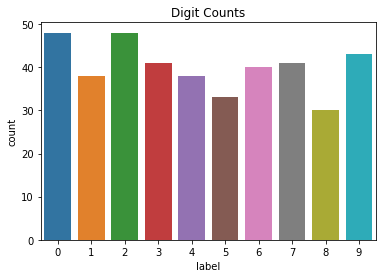

In [ ]:
# Read in the raw data
test_size = 400
train_data = pd.read_csv(paths["Training"], sep=",").astype(np.int32)
if TEST:
    train_data = train_data.head(test_size)
train_data = train_data.reindex(np.random.permutation(train_data.index))
ax = sns.countplot(x="label", data=train_data)
ax.set_title("Digit Counts")
train_labels = train_data.pop(target_label)

In [ ]:
# Make a validation set from the training data (80/20)
t_size = int(0.8 * train_data.shape[0])
validation_labels = train_labels[t_size:]
train_labels = train_labels[:t_size]
train_data = np.asarray(train_data, dtype=np.int32)
validation_data = train_data[t_size:]
train_data = train_data[:t_size]

sess = tf.Session()
with sess.as_default():
    
    print(train_data.shape)
    train_data = tf.reshape(train_data, [-1, 28, 28, 1])
    train_data = tf.image.resize_images(train_data, (96, 96))
    train_data = tf.image.grayscale_to_rgb(train_data)
    train_data = train_data.eval()
    print("1", type(train_data))
    module = hub.Module(TFHUB_MODULE)
    train_data = module(train_data)
    print("2", train_data, type(train_data))
    train_data = np.array(np.squeeze(train_data))
    print("3", train_data, type(train_data))

    print(validation_data.shape)
    validation_data = tf.reshape(validation_data, [-1, 28, 28, 1])
    validation_data = tf.image.resize_images(validation_data, (96, 96))
    validation_data = tf.image.grayscale_to_rgb(validation_data)
    validation_data = validation_data.eval()
    print("1", type(validation_data))
    module = hub.Module(TFHUB_MODULE)
    validation_data = module(validation_data)
    print("2", validation_data, type(validation_data))
    validation_data = np.array(np.squeeze(validation_data))
    print("3", validation_data, type(validation_data))

eval_data = pd.read_csv(paths["Testing"], sep=",").astype(np.int32)
eval_labels = pd.read_csv(paths["Submission"], sep=",").pop("Label")
if TEST:
    eval_data = eval_data.head(test_size)
    eval_labels = eval_labels.head(test_size)

(320, 784)


In [100]:
print("TRAINING")
print(train_data.shape, type(train_data))
print(train_data)
print(train_labels.shape, type(train_labels), train_labels.dtype)
print("-" * 40)
print("VALIDATION")
print(validation_data.shape, type(validation_data))
print(validation_data)
print(validation_labels.shape, type(validation_labels), validation_labels.dtype)
print("-" * 40)
print("EVALUATION")
print(eval_data.shape, type(eval_data))
print(eval_labels.shape, type(eval_labels), eval_labels.dtype)
print(eval_labels)
print(set(eval_labels))

TRAINING
() <class 'numpy.ndarray'>
Tensor("module_30_apply_default/MobilenetV2/Logits/output:0", shape=(320, 1001), dtype=float32)
(320,) <class 'pandas.core.series.Series'> int32
----------------------------------------
VALIDATION
() <class 'numpy.ndarray'>
Tensor("module_31_apply_default/MobilenetV2/Logits/output:0", shape=(80, 1001), dtype=float32)
(80,) <class 'pandas.core.series.Series'> int32
----------------------------------------
EVALUATION
(400, 784) <class 'pandas.core.frame.DataFrame'>
(400,) <class 'pandas.core.series.Series'> int64
0      0
1      0
2      0
3      0
4      0
      ..
395    0
396    0
397    0
398    0
399    0
Name: Label, Length: 400, dtype: int64
{0}


[32, 8, 4]
Training model...
Metrics:
	PERIOD	TYPE	TRAIN.	VALID.
	0	LgLs	30.76	32.38
		Acc.	10.94%	6.25%

	1	LgLs	31.52	30.22
		Acc.	8.75%	12.50%

	2	LgLs	31.52	30.22
		Acc.	8.75%	12.50%

	3	LgLs	31.52	30.22
		Acc.	8.75%	12.50%

Model training finished.
Final accuracy (on validation data): 12.5000%


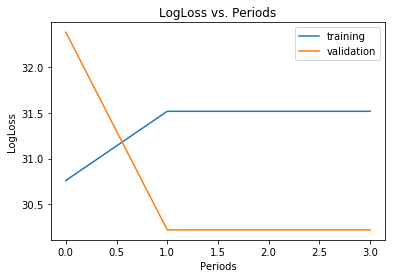

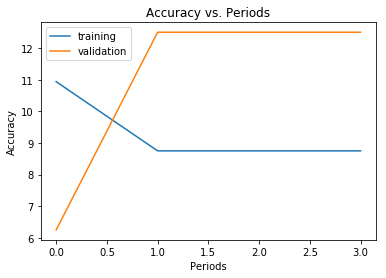

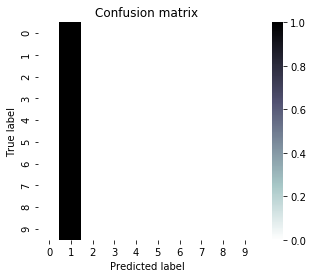

In [28]:
layers = 3
t_size = train_data.shape[1]
units = [nearest_2(math.ceil(t_size ** (1/i))) for i in range(2, 2+layers)]
print(units)
unitstr = "_".join([str(x) for x in units])

classifier, accuracy = train_nn_classification_model(
    learning_rate=LEARNING_RATE,
    steps=LEARNING_STEPS,
    hidden_units=units,
    batch_size=BATCH_SIZE,
    training_examples=train_data,
    training_targets=train_labels,
    validation_examples=validation_data,
    validation_targets=validation_labels)

In [29]:
fn = create_predict_input_fn(eval_data, eval_labels, batch_size=50)
ids = [x for x in range(1, 1 + eval_data.shape[0])]
predictions = np.array([item['class_ids'][0] for item in classifier.predict(input_fn=fn)])
output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)
t_accuracy = 100 * accuracy_score(eval_labels["Label"], predictions)
print("Final accuracy (on test data compared to sample submission): %0.4f%%" % t_accuracy)

InvalidArgumentError: Input to reshape is a tensor with 39200 values, but the requested shape has 50050
	 [[Node: dnn/input_from_feature_columns/input_layer/pixels/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dnn/input_from_feature_columns/input_layer/pixels/ToFloat, dnn/input_from_feature_columns/input_layer/pixels/Reshape/shape)]]

Caused by op 'dnn/input_from_feature_columns/input_layer/pixels/Reshape', defined at:
  File "/home/wesleytocs/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/wesleytocs/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-6a3e8d2e528d>", line 3, in <module>
    predictions = np.array([item['class_ids'][0] for item in classifier.predict(input_fn=fn)])
  File "<ipython-input-29-6a3e8d2e528d>", line 3, in <listcomp>
    predictions = np.array([item['class_ids'][0] for item in classifier.predict(input_fn=fn)])
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 496, in predict
    features, None, model_fn_lib.ModeKeys.PREDICT, self.config)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 831, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/canned/dnn.py", line 347, in _model_fn
    config=config)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/canned/dnn.py", line 183, in _dnn_model_fn
    logits = logit_fn(features=features, mode=mode)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/canned/dnn.py", line 91, in dnn_logit_fn
    features=features, feature_columns=feature_columns)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/feature_column/feature_column.py", line 277, in input_layer
    trainable, cols_to_vars)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/feature_column/feature_column.py", line 206, in _internal_input_layer
    array_ops.reshape(tensor, shape=(batch_size, num_elements)))
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6113, in reshape
    "Reshape", tensor=tensor, shape=shape, name=name)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/wesleytocs/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input to reshape is a tensor with 39200 values, but the requested shape has 50050
	 [[Node: dnn/input_from_feature_columns/input_layer/pixels/Reshape = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dnn/input_from_feature_columns/input_layer/pixels/ToFloat, dnn/input_from_feature_columns/input_layer/pixels/Reshape/shape)]]


In [ ]:
if not TEST:
    name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
    print("Outputting to: '{}'".format(name))
    output.to_csv(name, index=False)